In [1]:
import numpy as np  
import matplotlib.pyplot as plt
% matplotlib inline

### Utility functions ###

Initialize graph with parameters for Q and S (D=Q+S)

In [2]:
def init_graph(L, N):
    mu_Q = (np.random.rand(N*L))*np.ones(L).repeat(N)
    mu_Q = mu_Q.reshape((L,N))
    mu_S = (np.random.rand(N*L))*np.ones(L).repeat(N)
    mu_S = mu_S.reshape((L,N))
    sig_Q = (np.random.rand(N*L))*np.ones(L).repeat(N)
    sig_Q = sig_Q.reshape((L,N))
    sig_S = (np.random.rand(N*L))*np.ones(L).repeat(N)
    sig_S = sig_S.reshape((L,N))
    
    return {"mu_Q":mu_Q, "mu_S":mu_S, "sig_Q": sig_Q, "sig_S": sig_S}

Given a LxN graph, pick a pair of paths that differ only by ith node fo layer *layer*

In [3]:
def path_pair(layer, i, L, N):
    path_a = np.random.choice(N, L)
    path_b = path_a.copy()
    path_a[layer] = i
    path_b[layer] = (i+1)%N
    
    return path_a, path_b

Draw P random delays for each node according to their distributions

In [4]:
def draw_delays(mu, std, P, distr):
    L = mu.shape[0]
    N = mu.shape[1]
    draw = []
    
    if distr == "exp":
        return np.random.exponential(mu, size=(P,L,N))
    if distr == "gaussian":
        return np.add(mu, np.multiply(std, np.random.randn(P,L,N)))

Approximate the deviations for all the nodes of a layer

In [99]:
def approximate_deviations(layer, graph, distr, P):
    L = graph["mu_Q"].shape[0]
    N = graph["mu_Q"].shape[1]
    coefs = np.arange(1,N+1)[::-1]
            
    delays_Q = draw_delays(graph["mu_Q"], graph["sig_Q"], P, distr["Q"])
    delays_S = draw_delays(graph["mu_S"], graph["sig_S"], P, distr["S"])
    D = delays_Q + delays_S

    mu_deltas = np.zeros(N)
    var_deltas = np.zeros(N)

    for node in range(N):
        path_A, path_B = path_pair(layer, node, L, N)
        mu_delay_A = D[:, np.arange(L), path_A].sum(axis=1).mean()
        mu_delay_B = D[:, np.arange(L), path_B].sum(axis=1).mean()
        mu_deltas[node] = mu_delay_A-mu_delay_B
        
        var_delay_A = D[:, np.arange(L), path_A].sum(axis=1).var()
        var_delay_B = D[:, np.arange(L), path_B].sum(axis=1).var()
        var_deltas[node] = var_delay_A-var_delay_B
            
    mu_deviations = np.zeros(N)
    var_deviations = np.zeros(N)
    for i in range(N):
        mu_deviations[i] += np.sum(mu_deltas*coefs)/(N-1)
        var_deviations[i] += np.sum(var_deltas*coefs)/(N-1)
        coefs = np.roll(coefs, 1)
    return mu_deviations, var_deviations

Returns the true and approximated deviations of a given layer

In [154]:
def simulate_layer(g, layer, P, distr):
    mu_approx, var_approx = approximate_deviations(layer, g, distr, P)
    #true_devs = g["Q"][layer,:]+g["S"][layer,:] - np.mean(g["Q"][layer,:]+g["S"][layer,:])

    mu_true = []
    N = g["mu_Q"].shape[1]
    layer_sum = np.sum(g["mu_Q"][layer,:]+g["mu_S"][layer,:])
    for node in range(N):
        node_delay = g["mu_Q"][layer,node]+g["mu_S"][layer,node]
        node_dev = node_delay - (layer_sum - node_delay)/(N-1)
        mu_true.append(node_dev)

    var_true = []
    N = g["mu_Q"].shape[1]
    sig_2 = np.power(g["sig_Q"][layer,:],2)+np.power(g["sig_S"][layer,:],2) #square it to get the variance
    layer_sum = np.sum(sig_2)
    for node in range(N):
        node_delay = sig_2[node]
        node_dev = node_delay - (layer_sum - node_delay)/(N-1)
        var_true.append(node_dev)
    
    return mu_approx, var_approx, mu_true, var_true

Plot approximated deviations against true deviations

In [155]:
def plot_approx(approx_devs, true_devs):
    plt.scatter(range(N), (N/(N-1))*approx_devs, label="approx")
    plt.scatter(range(N), (N/(N-1))*true_devs, label="true")
    plt.legend(loc="best")


## Performance Monitoring: 2 nodes go wild [mu_S] ###

Generate a graph with random distribution means

In [164]:
N = 5
L = 5
distr ={"Q":"exp", "S":"gaussian"}

graph = init_graph(L, N)
graph["mu_Q"][1:]*=50
graph["mu_Q"][1:]+=50
graph["mu_Q"][0] +=5

graph["mu_S"][1:]*=50
graph["mu_S"][1:]+=50
graph["mu_S"][0] +=5

graph["sig_Q"][:] =0
graph["sig_S"][:] =1

graph

{'mu_Q': array([[  5.73544132,   5.95192916,   5.80675192,   5.27194814,
           5.40146328],
        [ 88.56785145,  70.44743005,  86.09497633,  60.86851628,
          85.00768043],
        [ 62.83556183,  80.29143107,  73.78808458,  67.43582027,
          58.00567336],
        [ 96.52421129,  84.46948004,  94.09450192,  75.57676812,  76.4957734 ],
        [ 65.40635572,  93.65577021,  54.79341351,  79.93440725,
          71.77314193]]),
 'mu_S': array([[  5.72238235,   5.43260313,   5.10414826,   5.55277885,
           5.30379862],
        [ 67.48947834,  82.15765439,  69.53321692,  69.50739128,
          97.65233817],
        [ 71.1285132 ,  55.27453776,  67.01153442,  71.0589773 ,
          59.47393362],
        [ 90.31006023,  76.28756766,  56.52856124,  56.44589653,
          64.56850807],
        [ 70.06611311,  92.64043358,  83.11213232,  73.11287194,
          88.22360338]]),
 'sig_Q': array([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  

Monitor the layer for 700 timesteps, and after timestep 100, gradually increase mu_S for node 0, and at time 350 gradually increase for mu_S for node 1

In [165]:

P=5000
mu_approx, mu_truth = [], []
var_approx, var_truth = [], []

for o in range(701):
    for layer in range(L):
        for node in range(N):
            if o > 100:
                graph["mu_S"][0][0] += np.random.rand()*0.01
            if o > 350:
                graph["mu_S"][0][1] += np.random.rand()*0.01
    mu_a, var_a, mu_t, var_t = simulate_layer(graph, layer=0, P=P, distr=distr)
    mu_approx.append(mu_a)
    var_approx.append(var_a)
    mu_truth.append(mu_t)
    var_truth.append(var_t)

graph["mu_S"], graph["sig_S"]

(array([[ 80.84189586,  49.39272221,   5.10414826,   5.55277885,
           5.30379862],
        [ 67.48947834,  82.15765439,  69.53321692,  69.50739128,
          97.65233817],
        [ 71.1285132 ,  55.27453776,  67.01153442,  71.0589773 ,
          59.47393362],
        [ 90.31006023,  76.28756766,  56.52856124,  56.44589653,
          64.56850807],
        [ 70.06611311,  92.64043358,  83.11213232,  73.11287194,
          88.22360338]]), array([[ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.]]))

Plot the results

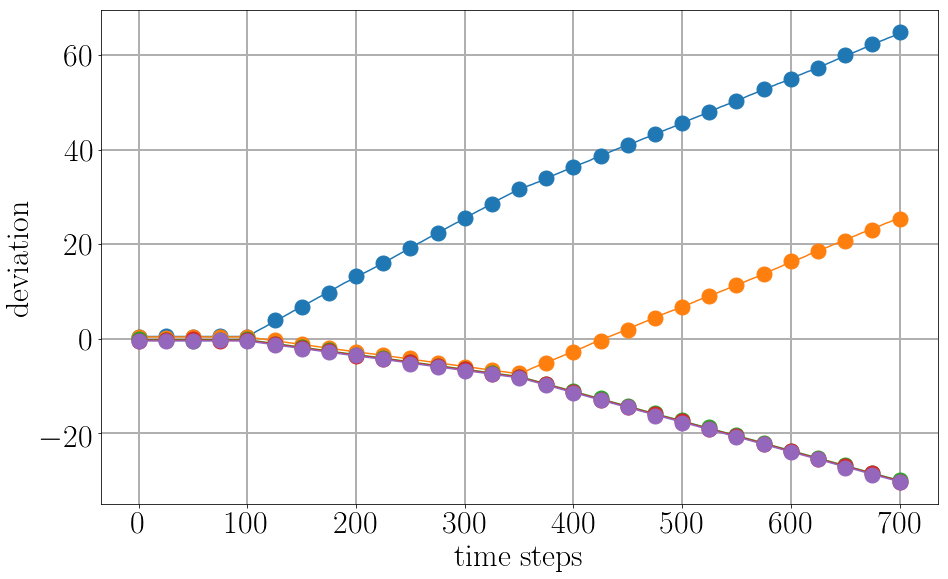

In [166]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"deviation",fontsize=32)
ax.set_xlabel(r"time steps",fontsize=32)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for n in range(N):
    x = [y[n] for y in mu_truth ]
    y = [z[n] for z in mu_approx ]
    plt.plot(x, label="$\widehat{\delta'}$", color=colors[n])
    plt.plot(y, label="$\delta'$", marker='o', markevery=25, markersize=15, linewidth=0)

plt.grid(linewidth=2)

## Performance Monitoring: 2 nodes go wild [sig_S] ###

In [167]:
N = 5
L = 5
distr ={"Q":"exp", "S":"gaussian"}

graph = init_graph(L, N)
graph["mu_Q"][1:]*=50
graph["mu_Q"][1:]+=50
graph["mu_Q"][0] +=5


graph["mu_S"][1:]*=50
graph["mu_S"][1:]+=50
graph["mu_S"][0] +=75

graph["sig_Q"][:] =0
graph["sig_S"][:] =1

graph

{'mu_Q': array([[  5.17369116,   5.23964086,   5.42523347,   5.35996537,
           5.71376081],
        [ 93.26272071,  72.81935484,  52.10557023,  56.43223617,
          62.11474602],
        [ 86.41847059,  98.57245998,  91.36697272,  67.10327063,
          97.76440905],
        [ 60.29758389,  80.48252511,  81.27437736,  81.87696207,
          82.78723719],
        [ 74.17891742,  51.84343837,  89.35107258,  76.16284577,
          96.05781439]]),
 'mu_S': array([[ 75.92598026,  75.7273582 ,  75.0067704 ,  75.9711508 ,
          75.58136296],
        [ 71.0416739 ,  60.7326798 ,  71.58157449,  84.73206491,
          78.30076143],
        [ 72.76954108,  98.30730614,  76.9406277 ,  62.73938502,
          78.81477899],
        [ 84.2031393 ,  87.57323932,  75.78737909,  95.61314808,
          85.41844869],
        [ 81.77811971,  82.67620355,  82.95216443,  94.78804323,
          78.64071287]]),
 'sig_Q': array([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0

Monitor the layer for 700 timesteps, and after timestep 100, gradually increase mu_S for node 0, and at time 350 gradually increase for mu_S for node 1

In [168]:

P=5000
mu_approx, mu_truth = [], []
var_approx, var_truth = [], []

for o in range(701):
    for layer in range(L):
        for node in range(N):
            if o > 100:
                graph["sig_S"][0][0] += np.random.rand()*0.01
            if o > 350:
                graph["sig_S"][0][1] += np.random.rand()*0.01
    mu_a, var_a, mu_t, var_t = simulate_layer(graph, layer=0, P=P, distr=distr)
    mu_approx.append(mu_a)
    var_approx.append(var_a)
    mu_truth.append(mu_t)
    var_truth.append(var_t)

graph["mu_S"], graph["sig_S"]

(array([[ 75.92598026,  75.7273582 ,  75.0067704 ,  75.9711508 ,
          75.58136296],
        [ 71.0416739 ,  60.7326798 ,  71.58157449,  84.73206491,
          78.30076143],
        [ 72.76954108,  98.30730614,  76.9406277 ,  62.73938502,
          78.81477899],
        [ 84.2031393 ,  87.57323932,  75.78737909,  95.61314808,
          85.41844869],
        [ 81.77811971,  82.67620355,  82.95216443,  94.78804323,
          78.64071287]]),
 array([[ 75.38311017,  44.72066141,   1.        ,   1.        ,   1.        ],
        [  1.        ,   1.        ,   1.        ,   1.        ,   1.        ],
        [  1.        ,   1.        ,   1.        ,   1.        ,   1.        ],
        [  1.        ,   1.        ,   1.        ,   1.        ,   1.        ],
        [  1.        ,   1.        ,   1.        ,   1.        ,   1.        ]]))

Plot the **mu** monitoring results (***we see nothing conclusive***)

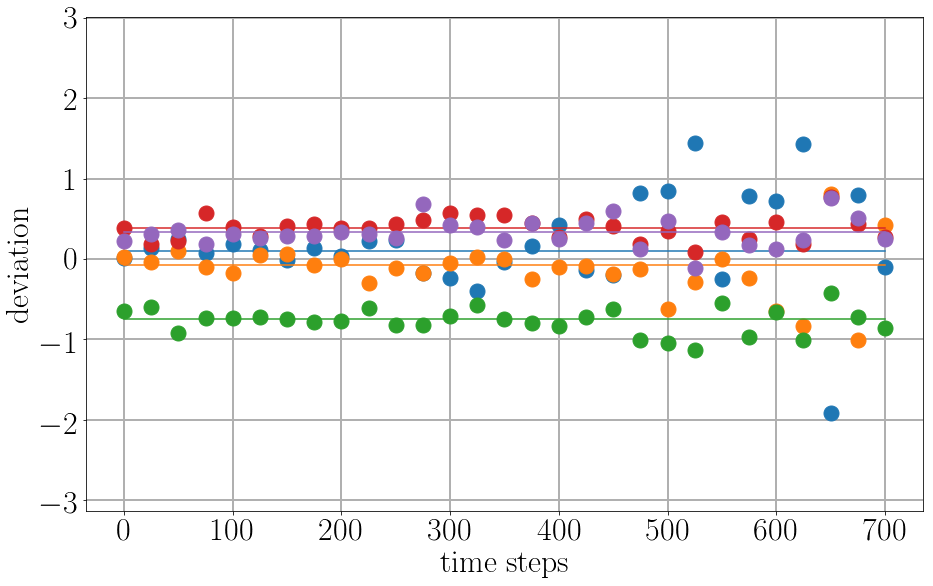

In [169]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"deviation",fontsize=32)
ax.set_xlabel(r"time steps",fontsize=32)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for n in range(N):
    x = [y[n] for y in mu_truth ]
    y = [z[n] for z in mu_approx ]
    plt.plot(x, label="$\widehat{\delta'}$", color=colors[n])
    plt.plot(y, label="$\delta'$", marker='o', markevery=25, markersize=15, linewidth=0)

plt.grid(linewidth=2)

Plot the **sig** monitoring results (***we see some node having much greater variance***)

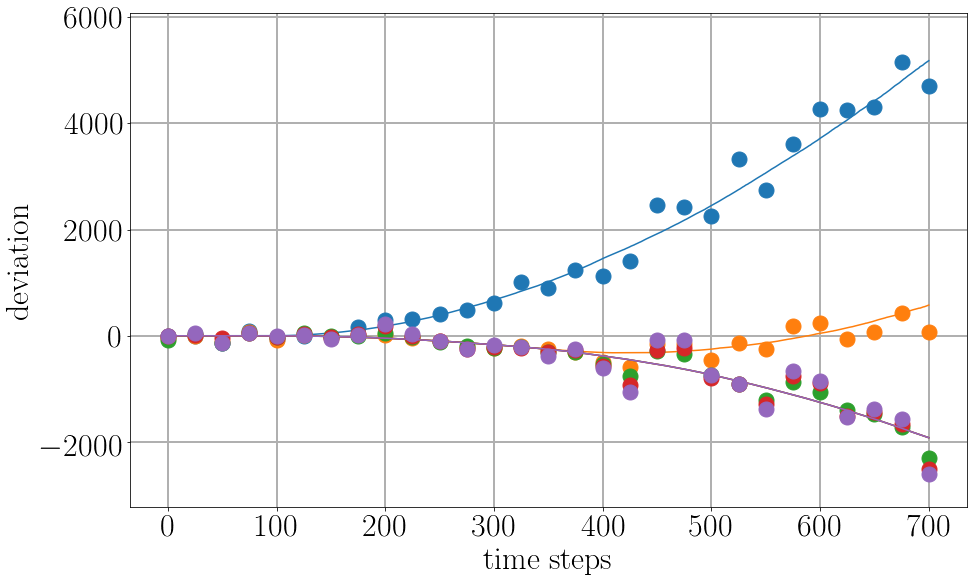

In [170]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"deviation",fontsize=32)
ax.set_xlabel(r"time steps",fontsize=32)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for n in range(N):
    x = [y[n] for y in var_truth ]
    y = [z[n] for z in var_approx ]
    plt.plot(x, label="$\widehat{\delta'}$", color=colors[n])
    plt.plot(y, label="$\delta'$", marker='o', markevery=25, markersize=15, linewidth=0)

plt.grid(linewidth=2)

### Performance Monitoring and Random Walk : everything is moving in EVERY LAYER - not only layer 0 ###

Generate a graph with random distribution means

In [124]:
N = 5
L = 5
graph = init_graph(L, N)
graph["mu_Q"][1:]*=50
graph["mu_Q"][1:]+=50
graph["mu_Q"][0] +=5

graph["mu_S"][1:]*=50
graph["mu_S"][1:]+=50
graph["mu_S"][0] +=5

graph

KeyError: 'Q'

Monitor the layer for 502 timesteps, and after timestep 100, turn on the random walk for every node of the graph

In [ ]:

P=250
approx, truth = [], []
distr ={"Q":"exp", "S":"exp"}
for o in range(502):
    for layer in range(L):
        for node in range(N):
            if o > 100:
                graph["S"][layer][node] += np.random.rand()-0.5
                graph["S"][layer][node] = abs(graph["S"][layer][node])
    a, t = simulate_layer(graph, layer=0, P=P, distr=distr)
    approx.append(a)
    truth.append(t)
graph

Plot the results

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"deviation",fontsize=32)
ax.set_xlabel(r"time steps",fontsize=32)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for n in range(N):
    x = [y[n] for y in truth ]
    y = [z[n] for z in approx ]
    plt.plot(x, label="$\widehat{\delta'}$", color=colors[n])
    plt.plot(y, label="$\delta'$", marker='o', markevery=25, markersize=15, linewidth=0)

plt.grid(linewidth=2)

### Sensitivity, Error and Sample Size ###

Compute and return the absolute difference bewteen true and approximated delays

In [ ]:
def abs_diff_samples(graph, P, distr):
    L = graph["Q"].shape[0]
    diff = np.array([])
    for layer in range(L):
        a, t = simulate_layer(graph, layer=layer, P=P, distr=distr)
        diff = np.concatenate((diff, np.abs(a-t)))
    return diff

In [ ]:
N = 10
L = 10
distr = {"Q":"exp", "S":"gaussian"}
diffs = {}
graph = init_graph(L,N)
graph["Q"] *= 100
graph["S"] *= 100

for p in [100, 250, 1000, 5000, 50000]:
    diffs[p] = abs_diff_samples(graph, p, distr)

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"$|\delta' - \widehat{\delta'}|$",fontsize=32)
ax.set_xlabel(r"graph nodes",fontsize=32)
#ax.set_title(r"normal distribution",fontsize=32)


for d in sorted(diffs):
    label = "p=" + str(d)
    if d > 500:
        label = "p=" +str(int(d/1000))+"k"        
    plt.plot(sorted(diffs[d], reverse=True), label=label, linewidth=4)
plt.legend(loc="best")
plt.grid(linewidth=2)

### Work in progress : Layer scale approximation ###

In [ ]:
N = 11
L = 21
sigma=0.5
graph = init_graph(L,N)

betas = sorted(np.random.rand(L))

for i in range(L):
    graph[i] += 20*betas[i]        
    graph[i] *= np.ones(N) + 0.05*np.random.rand(N)

    

graph

In [ ]:
times=250
A  = np.zeros((L, N, times))
T  = np.zeros((L, N, times))

for i in range(times):
    print(i)
    for l in range(L):
        a, t  = simulate_layer(graph, layer=l, P=50, distr="normal")
        A[l,:,i] = a
        T[l,:,i] = t

In [ ]:
#data = np.abs(A).mean(axis=(1,2))
#data_t = np.abs(T).mean(axis=(1,2))

data = np.abs(A).mean(axis=(2)).sum(axis=1)
#data_t = np.abs(T).median(axis=(1,2))

In [ ]:
graph[8]

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"$\overline{|\delta'_{l,i}|}$",fontsize=32, rotation=0)
ax.yaxis.set_label_coords(-0.075,0.5)

ax.set_xlabel(r"layer index ($l$)",fontsize=32)

plt.plot(range(1,L+1), data,  label=r"$\overline{\beta_{l}} \approx l,  \forall l$")
plt.plot(range(1,L+1), 2*np.sqrt(graph*sigma).mean(axis=1), label="beta")
#plt.plot(range(1,L+1), graph.mean(axis=1)*(sigma), label="beta")

#plt.plot(range(1,L+1), np.power(graph.std(axis=1),20), label="beta")

#plt.plot(range(1,L+1), graph.mean(axis=1)/data, label="beta")


plt.grid(linewidth=2)
plt.legend(loc="best")
